In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import os
import time


Load data from parquet files

In [4]:
# define property names 
props = ('G', 'S', 'U', 'H', 'A', 'rho', 'Cp') #, 'Kt', 'Kp', 'Ks', 'alpha', 'vel', 'mus', 'muw', 'Vm', 'Cpm', 'Cpa', 'Va', 'Vex', 'phi', 'aw', 'gam', 'Gex')

# Define directory for G data  
dirG = os.path.join('/Users/ulajones/Documents/School/ESS/ESS569F24/data/ai_ready/', 'G')
os.makedirs(dirG, exist_ok=True)
dfG = pq.read_table(os.path.join(dirG, 'NaCl_G.parquet')).to_pandas()

# Initialize data_j with headers
data_j = pd.DataFrame(columns=['P_Mpa', 'T_K', 'm_molkg'] + list(props))

# Add G data to data_j
data_j['P_Mpa'] = dfG['P_Mpa']
data_j['T_K'] = dfG['T_K']
data_j['m_molkg'] = dfG['m_molkg']

for j in props: 
    dir_ready = os.path.join('/Users/ulajones/Documents/School/ESS/ESS569F24/data/ai_ready/', j)
    os.makedirs(dir_ready, exist_ok=True)
    df = pq.read_table(os.path.join(dir_ready, f'NaCl_{j}.parquet')).to_pandas()
    
    # Filter data for pressures below 2 GPa (2000 MPa)
    df = df[df['P_Mpa'] < 2000]
    
    # Add property data to data_j
    data_j[f'{j}'] = df[f'{j}']

# Display the shape, first few rows of the structure to verify
print("Full DataFrame shape:", data_j.shape)
print(data_j.head())

Full DataFrame shape: (939401, 10)
   P_Mpa    T_K  m_molkg             G           S              U  \
0    0.1  240.0      0.0  -8926.550362 -582.447446 -148816.097810   
1   10.1  240.0      0.0   1243.813309 -565.772512 -144768.598346   
2   20.1  240.0      0.0  11326.998932 -552.246594 -141395.802828   
3   30.1  240.0      0.0  21328.899131 -541.372011 -138589.316172   
4   40.1  240.0      0.0  31254.927198 -532.721316 -136256.214314   

               H            A          rho           Cp  
0 -148713.937389 -9028.710783   978.852659  5300.978960  
1 -134541.589582 -8983.195455   987.581045  4987.894841  
2 -121212.183512 -8856.620385   995.857070  4744.177162  
3 -108600.383619 -8660.033422  1003.703615  4552.559071  
4  -96598.188562 -8403.098554  1011.144636  4399.396981  


In [5]:
# subset data by odd and even indicies

data_odd = data_j.iloc[1::2].reset_index(drop=True)
data_even = data_j.iloc[0::2].reset_index(drop=True)

# Display the first few rows of each subset to verify
print("Odd indices data:")
print(data_odd.head())

print("\nEven indices data:")
print(data_even.head())

Odd indices data:
   P_Mpa    T_K  m_molkg             G           S              U  \
0   10.1  240.0      0.0   1243.813309 -565.772512 -144768.598346   
1   30.1  240.0      0.0  21328.899131 -541.372011 -138589.316172   
2   50.1  240.0      0.0  41110.044021 -525.931116 -134317.671575   
3   70.1  240.0      0.0  60625.287112 -516.761941 -131371.216828   
4   90.1  240.0      0.0  79906.291074 -512.004183 -129349.153917   

               H            A          rho           Cp  
0 -134541.589582 -8983.195455   987.581045  4987.894841  
1 -108600.383619 -8660.033422  1003.703615  4552.559071  
2  -85113.423910 -8094.203644  1018.204777  4274.251148  
3  -63397.578736 -7348.350980  1031.282155  4079.752018  
4  -42974.712833 -6468.150009  1043.132654  3933.682864  

Even indices data:
   P_Mpa    T_K  m_molkg             G           S              U  \
0    0.1  240.0      0.0  -8926.550362 -582.447446 -148816.097810   
1   20.1  240.0      0.0  11326.998932 -552.246594 -141395.80

## 1. Metrics on training time for each model architecture

Like in the model training assessment notebook, the next cell uses sklearn's bagging regressor to examine 3 model architectures that were found to be effective for the regression in the auto_ml notebook. It then evaluates and collects performance metrics (MSE, R2) alongside training times to determine which model provides the best balance between speed and accuracy. Sklearn's bagging regressor is an ensemble learning method that takes random subsets of the test and training data and trains a given model architecture on it (the "base estimator" model). 

I'm using specific heat for this example because it is the best behaved variable when normalized using standard scaler, but by changing the target variable selected in the training set. 

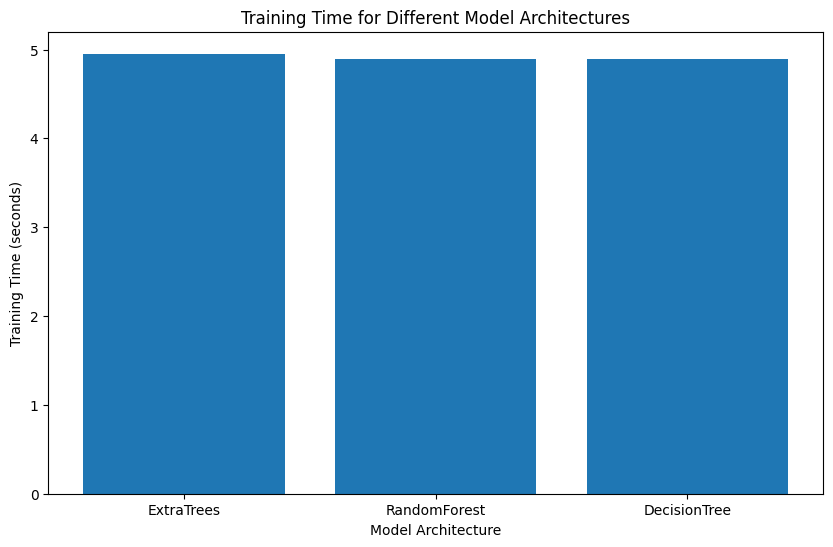

In [6]:
# Define features (X) and target (y) for training and test sets
X_train = data_odd[['P_Mpa', 'T_K', 'm_molkg']]
y_train = data_odd['Cp']
X_test = data_even[['P_Mpa', 'T_K', 'm_molkg']]
y_test = data_even['Cp']

# Combine odd and even data for cross-validation
X = pd.concat([X_train, X_test]).reset_index(drop=True)
y = pd.concat([y_train, y_test]).reset_index(drop=True)

# Normalize the Cp data
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Define different model architectures
models = {
    'ExtraTrees': ExtraTreesRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# Initialize and train BaggingRegressor for each model
bagging_models = {}
training_times = {}
for name, model in models.items():
    start_time = time.time()
    bagging_model = BaggingRegressor(n_estimators=10, random_state=42)
    bagging_model.fit(X_train, y_train)
    end_time = time.time()
    training_times[name] = end_time - start_time
    bagging_models[name] = bagging_model

# Plot training times
plt.figure(figsize=(10, 6))
plt.bar(training_times.keys(), training_times.values())
plt.xlabel('Model Architecture')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Different Model Architectures')
plt.savefig('training_times.png')
plt.show()


## 2. An exploration of time vs. accuracy trade-offs

In [7]:
# Time vs. Accuracy Trade-offs
accuracy_vs_time = {}
for name, model in bagging_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy_vs_time[name] = {'MSE': mse, 'R2': r2, 'Training Time': training_times[name]}

accuracy_vs_time_df = pd.DataFrame(accuracy_vs_time).T
print(accuracy_vs_time_df)

                  MSE       R2  Training Time
ExtraTrees    0.00003  0.99997       4.952647
RandomForest  0.00003  0.99997       4.887971
DecisionTree  0.00003  0.99997       4.891885


## 3. Assessment of expected time requirements for model deployment

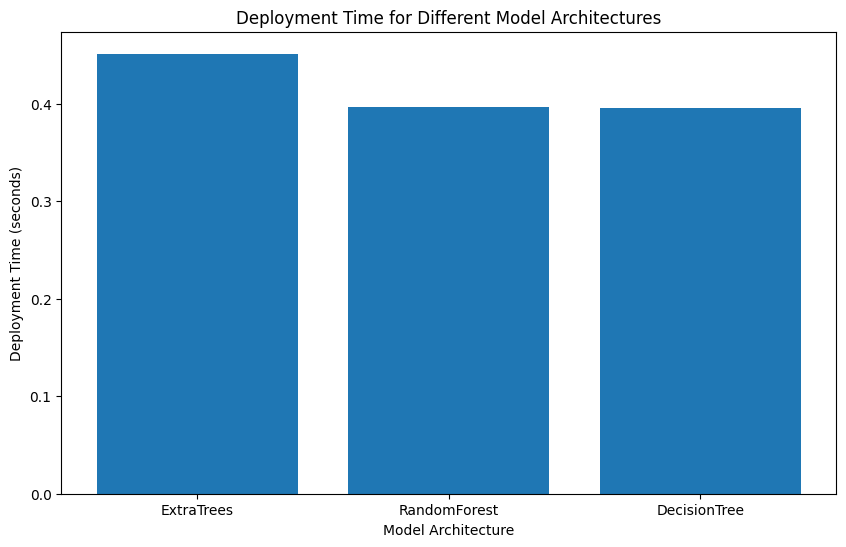

In [8]:
# Expected Deployment Time
deployment_times = {}
for name, model in bagging_models.items():
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    deployment_times[name] = end_time - start_time

# Plot deployment times
plt.figure(figsize=(10, 6))
plt.bar(deployment_times.keys(), deployment_times.values())
plt.xlabel('Model Architecture')
plt.ylabel('Deployment Time (seconds)')
plt.title('Deployment Time for Different Model Architectures')
plt.savefig('deployment_times.png')
plt.show()


 This notebook visualizes computational times required for training and deploying Extra Trees Regressor, Random Forest Regressor, and Decision Tree Regressor models using bootstrapping and bagging on the normalized Cp data. The DecisionTree model had the fastest time, but exhibited higher variance in performance; the RandomForest model fell in between; and the ExtraTrees model was the slowest and most accurate. Training time increases with model complexity, particularly for ensemble methods like ExtraTrees and RandomForest. However, deployment time remains relatively low for all cases, which is encouraging.